In [1]:
# Add parent folder to path, so that we can import local dh_modelling Python module
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from pathlib import Path
import time

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from dh_modelling.helpers import load_intermediate
from dh_modelling.evaluate import calculate_metrics

In [3]:
model_path = Path(module_path)/'models'/'model.bin'
model = xgb.Booster()
model.load_model(model_path)

# Model testing

Let's load test dataframe and check how the model works

In [4]:
df_test = load_intermediate(Path(module_path)/'data/processed/test.feather')
X_test, y_test = df_test.drop("dh_MWh", axis=1), df_test[["dh_MWh"]]

dtest = xgb.DMatrix(data=X_test, label=y_test)
model.feature_names = dtest.feature_names

In [11]:
predicted = model.predict(dtest)
actual = y_test.squeeze().to_numpy()

calculate_metrics(actual, predicted)

{'mean_absolute_error': 40.33140086892901,
 'mean_absolute_percentage_error': 0.07034724809023282,
 'root_mean_squared_error': 51.485809749772024}

7 % mean absolute percentage error is okay-ish, but really, could be better. 40 MW mean absolute error is tolerable, but less would be better.
We will see later if feature engineering helps in this.

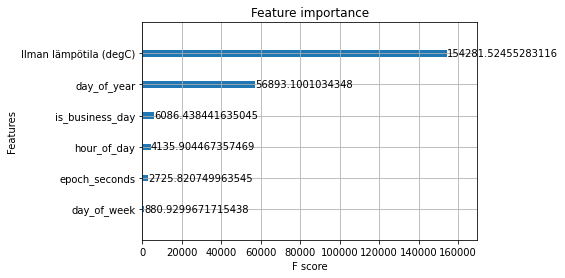

In [5]:
xgb.plot_importance(model, importance_type="gain")
plt.show()

It seems that the model determines ambient temperature to be the greatest driver, which is very much expected.

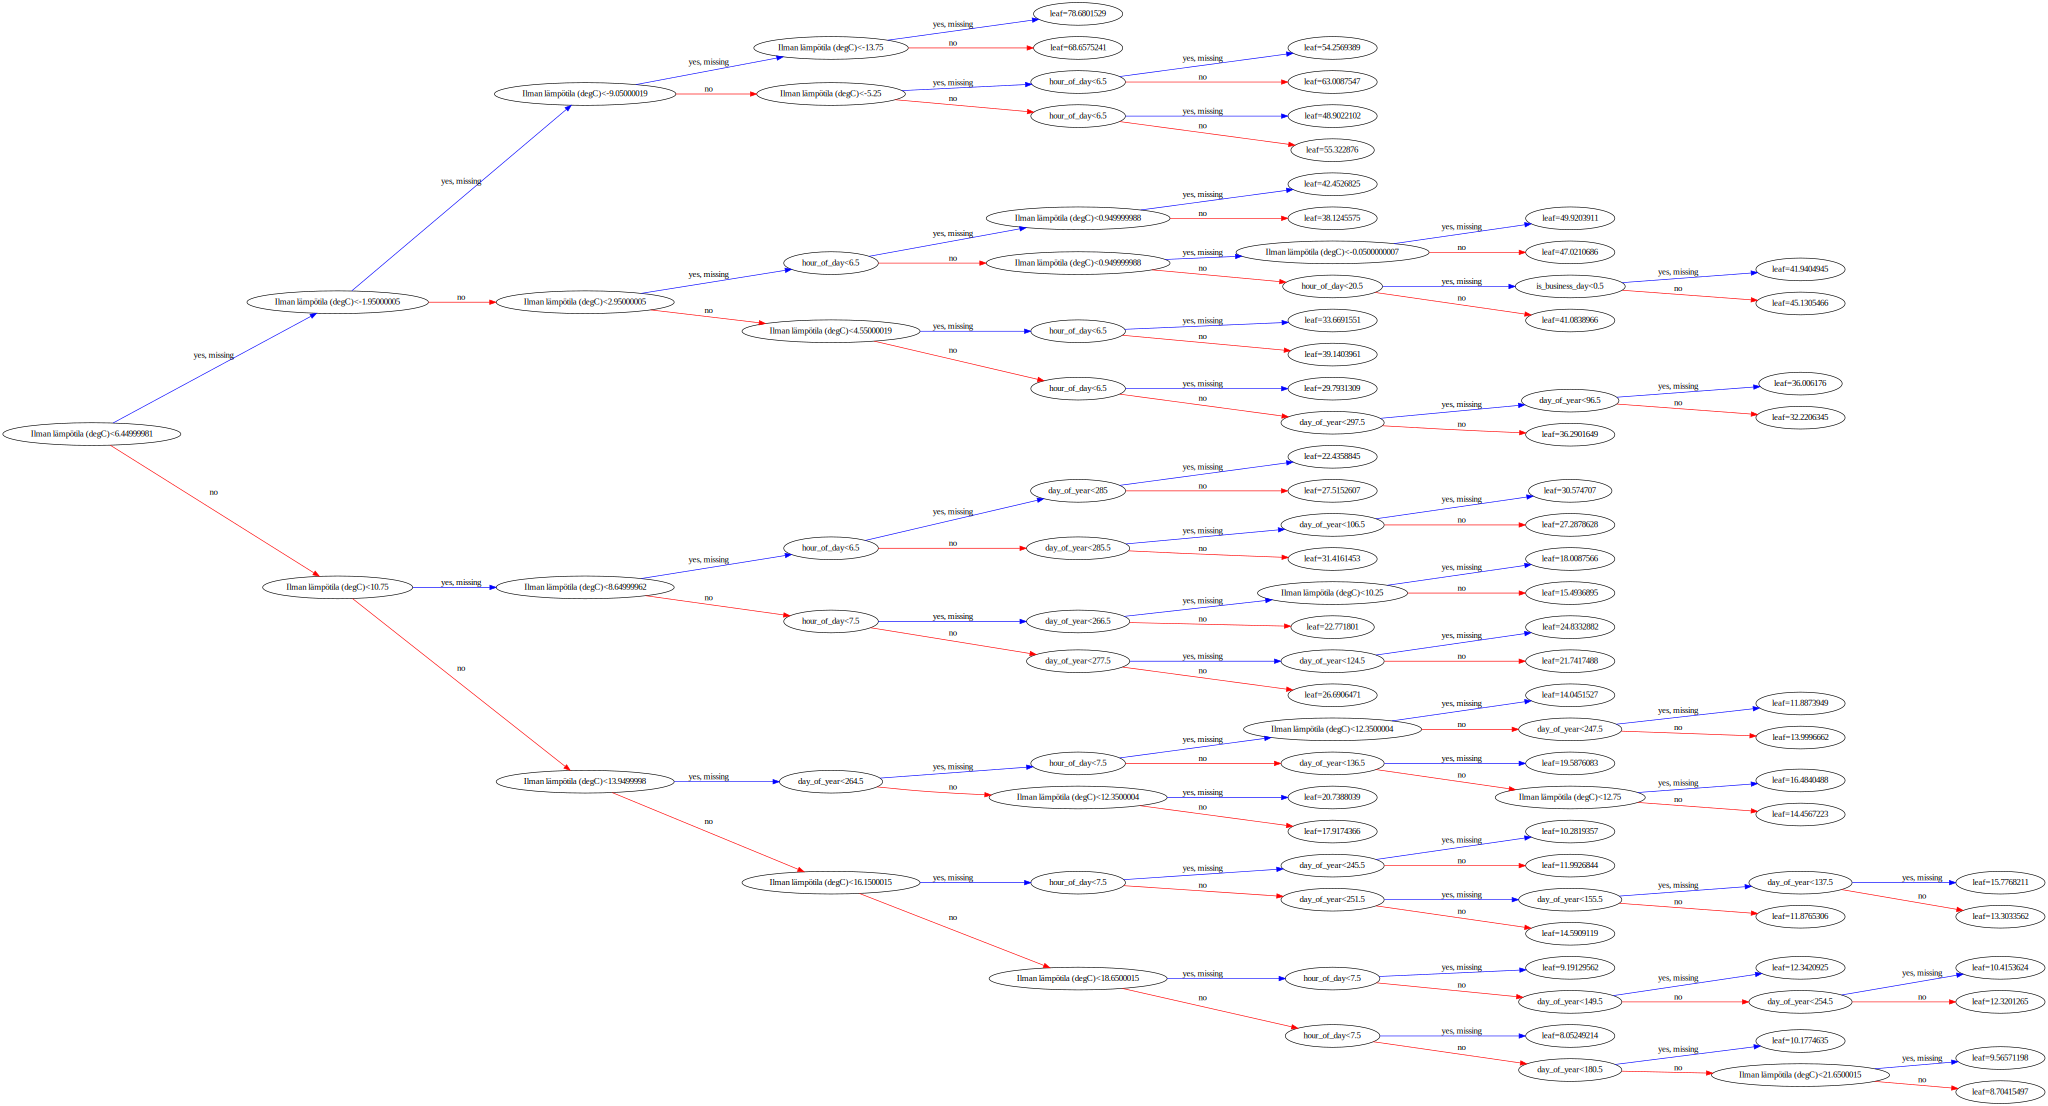

In [9]:
xgb.to_graphviz(model, rankdir="LR")

Let's see some predictions and explanation for the first week

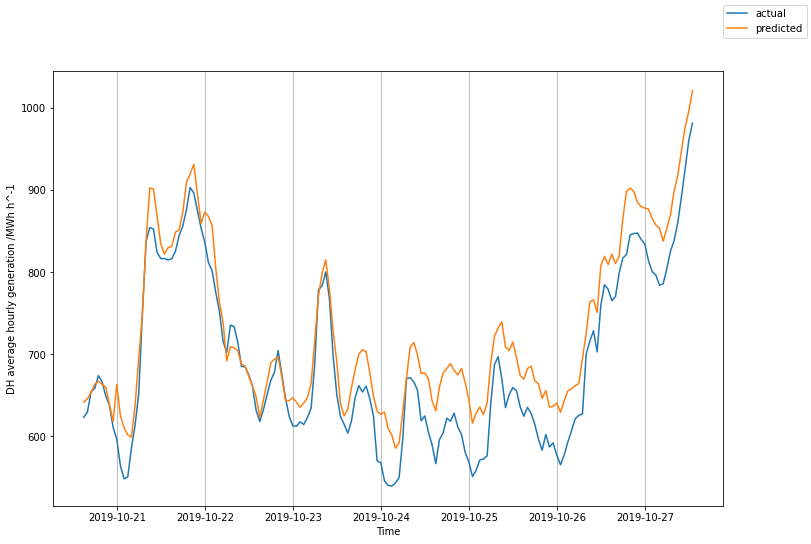

In [21]:
idx = slice(0,24*7-1)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df_test.index[idx], actual[idx], label='actual')
ax.plot(df_test.index[idx], predicted[idx], label='predicted')
ax.xaxis.grid()
ax.set_xlabel("Time")
ax.set_ylabel("DH average hourly generation /MWh h^-1")
fig.legend()
plt.show()

In [7]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

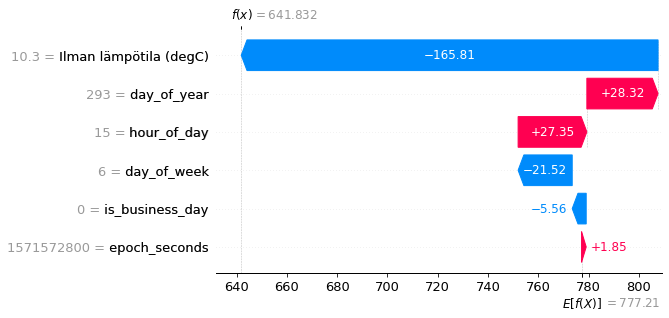

In [8]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

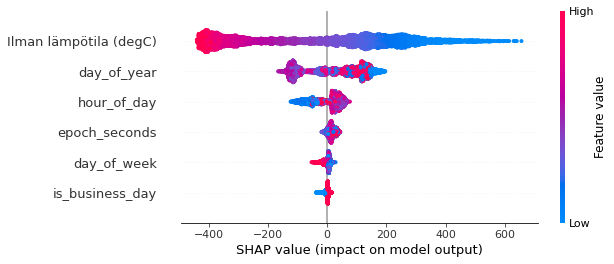

In [15]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

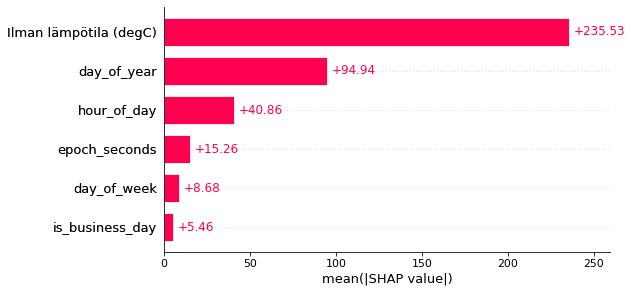

In [16]:
shap.plots.bar(shap_values)

Notes reasoned from the above:
- The model predicts a high impact on model output for low temperatures and low impact for high temperature. That is clear and obvious.
- The `day_of_year` is more diverse, and not much cannot be deduced. With medium feature values, the model output is reduced,
  but for both high and low values (near start/end of year) the value is increased.
  This tells a tale on the need of the need for sin/cosine encoding, to take into account the cyclic nature of years cycle.
- There's a bit similar need for `hour_of_day` variable, but not to that a great extent
- Variable `epoch_seconds` is really confusing. Better see how the model performs without it.
- Variables `day_of_week` and `is_business_day` mostly have the same effect.

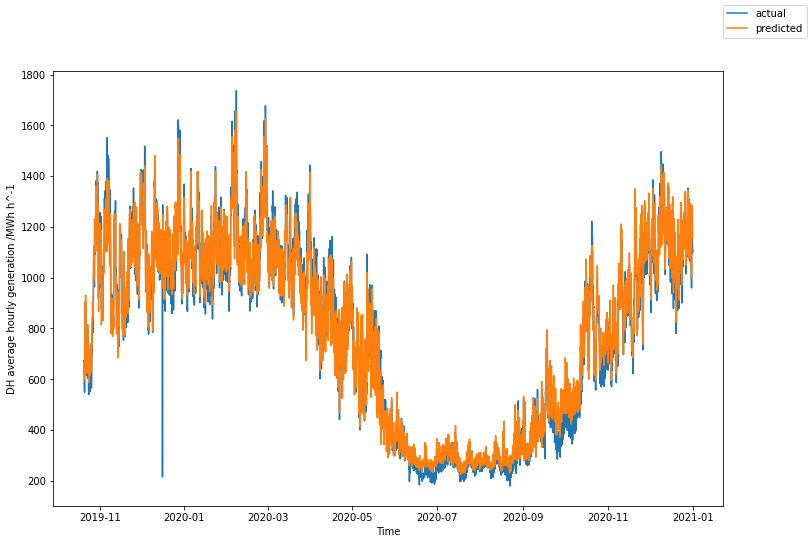

In [33]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df_test.index, actual, label='actual')
ax.plot(df_test.index, predicted, label='predicted')
ax.set_xlabel("Time")
ax.set_ylabel("DH average hourly generation /MWh h^-1")
fig.legend()
plt.show()

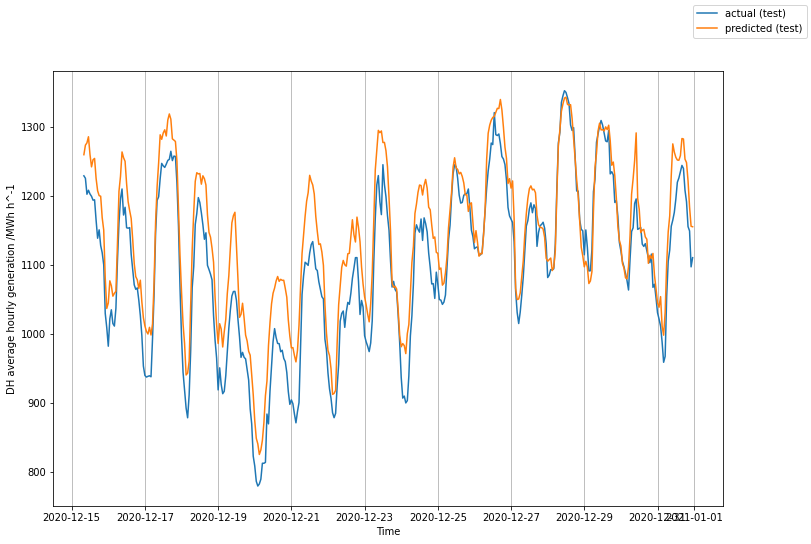

In [35]:
last_hours = 400

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df_test.index[-last_hours:], actual[-last_hours:], label='actual (test)')
ax.plot(df_test.index[-last_hours:], predicted[-last_hours:], label='predicted (test)')
ax.xaxis.grid()
ax.set_xlabel("Time")
ax.set_ylabel("DH average hourly generation /MWh h^-1")
fig.legend()
plt.show()

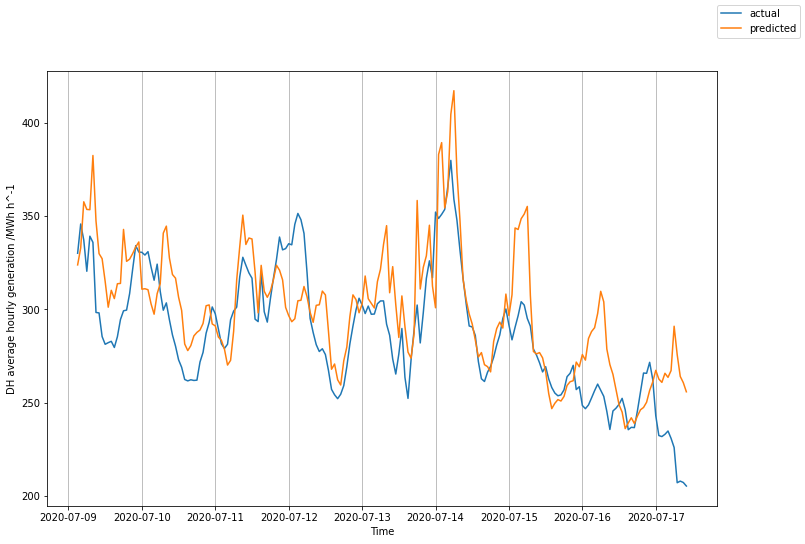

In [36]:
idx = slice(6300,6500)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df_test.index[idx], actual[idx], label='actual')
ax.plot(df_test.index[idx], predicted[idx], label='predicted')
ax.xaxis.grid()
ax.set_xlabel("Time")
ax.set_ylabel("DH average hourly generation /MWh h^-1")
fig.legend()
plt.show()

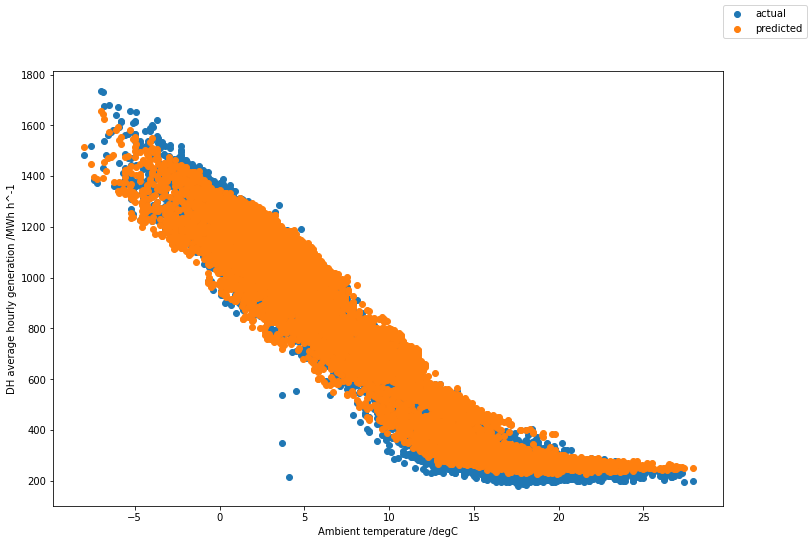

In [38]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x=X_test["Ilman lämpötila (degC)"], y=actual, label='actual')
ax.scatter(x=X_test["Ilman lämpötila (degC)"], y=predicted, label='predicted')
ax.set_xlabel("Ambient temperature /degC")
ax.set_ylabel("DH average hourly generation /MWh h^-1")
fig.legend()
plt.show()

The predictions seem to overestimate generation in the warmer period.

## When do errors occur?

<AxesSubplot:xlabel='hour_of_day', ylabel='error'>

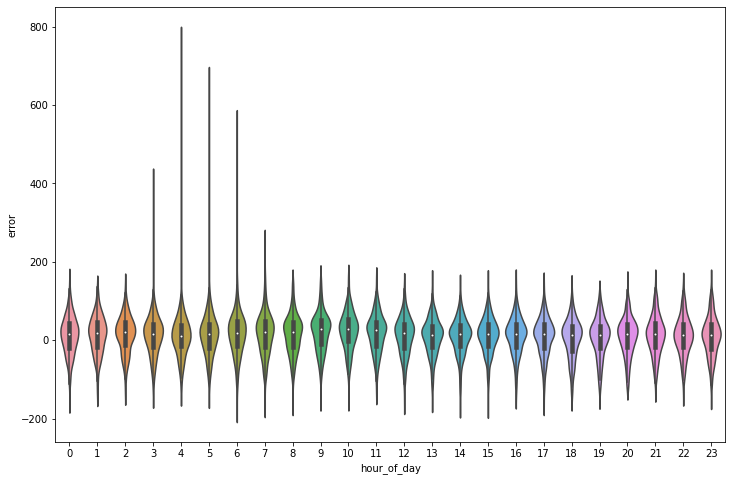

In [31]:
df_test['error'] = pd.Series(predicted - actual).values
df_test

import seaborn as sns

fig, ax = plt.subplots(figsize=(12,8))
sns.violinplot(data=df_test, x='hour_of_day', y='error', ax=ax)

We have to seek for better prediction during hours 3-6, when predictions are larger than actual values.

One possible explanation might be that during the wintertime, the DH storages are loaded during the night hours, when consumption is low and electricity prices are usually also lower. This needs to be investigated. That would then not happen in summer, and then the prediction would be larger than actual generation.

Possible features to add to the dataset:
- spot electricity price
- DH generation lag, cumulative generation from previous ~1-6 hours
- ambient temperature lead, average ambient temperature gradient for the next ~1-6 hours

Also, the test set could be shorter (last calendar year, or maybe even last six months)

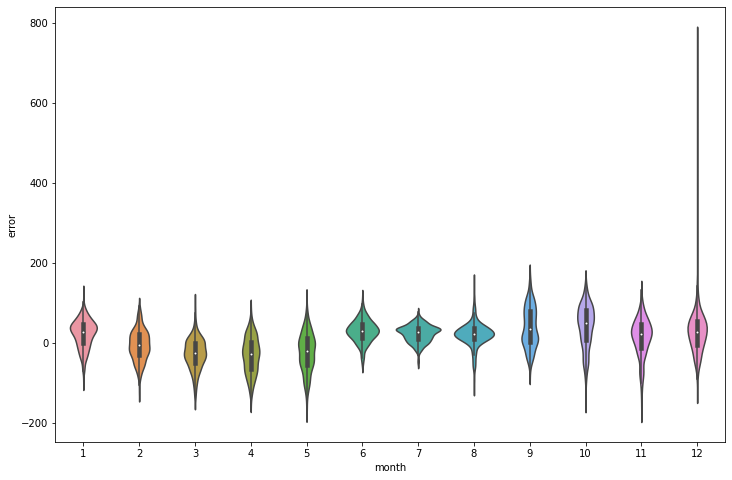

In [43]:
fig, ax = plt.subplots(figsize=(12,8))
df_test['month'] = df_test.index.month
sns.violinplot(data=df_test, x='month', y='error', ax=ax)
plt.show()

The outlier in 2019-12 is clearly visible over there. In general, there is more error during the colder season. The DH consumption is also lower in the summer, so that is not a big surprise.

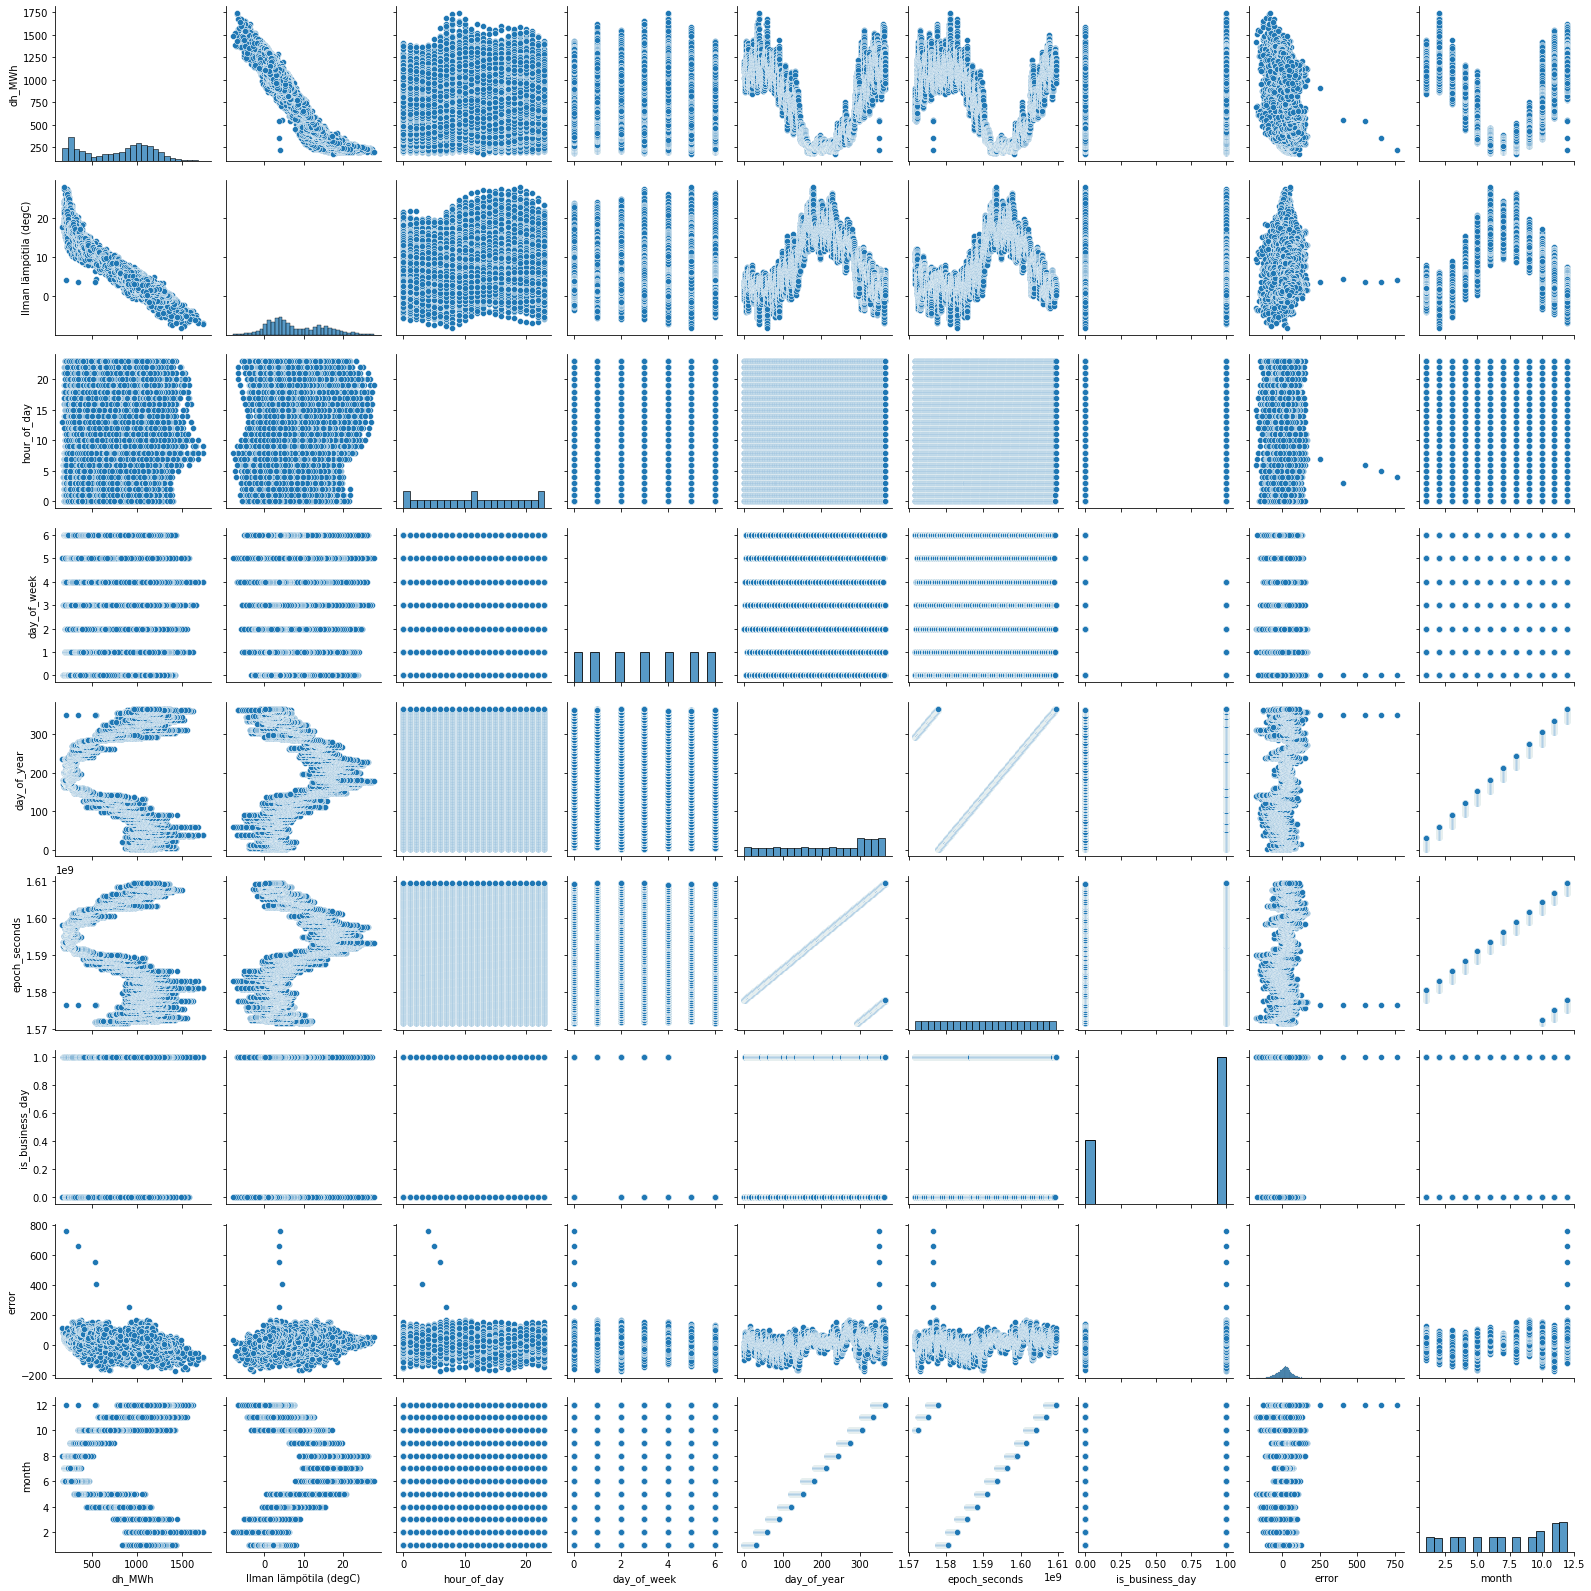

In [44]:
sns.pairplot(df_test)

In [46]:
greatest_error_indices = np.argsort(np.abs(df_test['error']))[::-1]
greatest_error_indices

date_time
2020-12-31 23:00:00+02:00    1358
2020-12-31 22:00:00+02:00    1359
2020-12-31 21:00:00+02:00    1360
2020-12-31 20:00:00+02:00    1357
2020-12-31 19:00:00+02:00    1361
                             ... 
2019-10-20 19:00:00+03:00    7545
2019-10-20 18:00:00+03:00    8683
2019-10-20 17:00:00+03:00    1192
2019-10-20 16:00:00+03:00    9865
2019-10-20 15:00:00+03:00    9396
Name: error, Length: 10522, dtype: int64

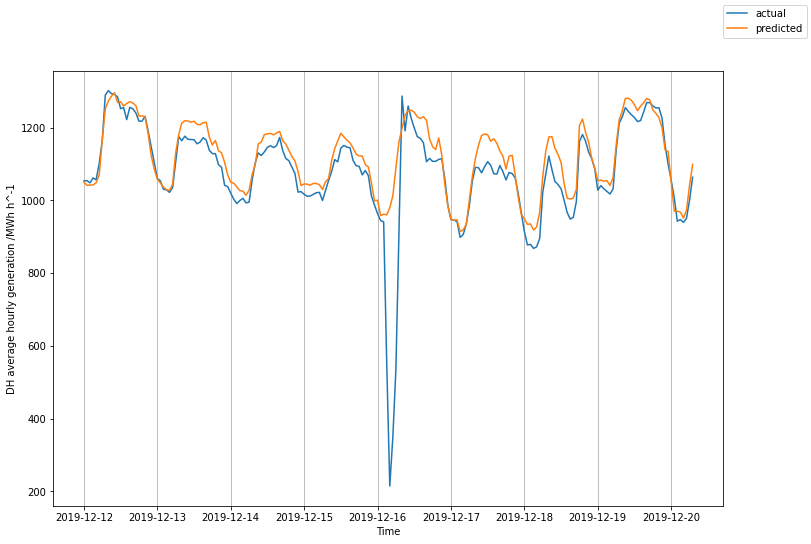

In [49]:
def plot_error_location(order, error_indices, delta=100):
    i = error_indices[order]
    idx = slice(i-delta,i+delta)

    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(df_test.index[idx], actual[idx], label='actual')
    ax.plot(df_test.index[idx], predicted[idx], label='predicted')
    ax.set_xlabel("Time")
    ax.set_ylabel("DH average hourly generation /MWh h^-1")
    ax.xaxis.grid()
    fig.legend()
    return fig

fig = plot_error_location(0, greatest_error_indices)
plt.show()

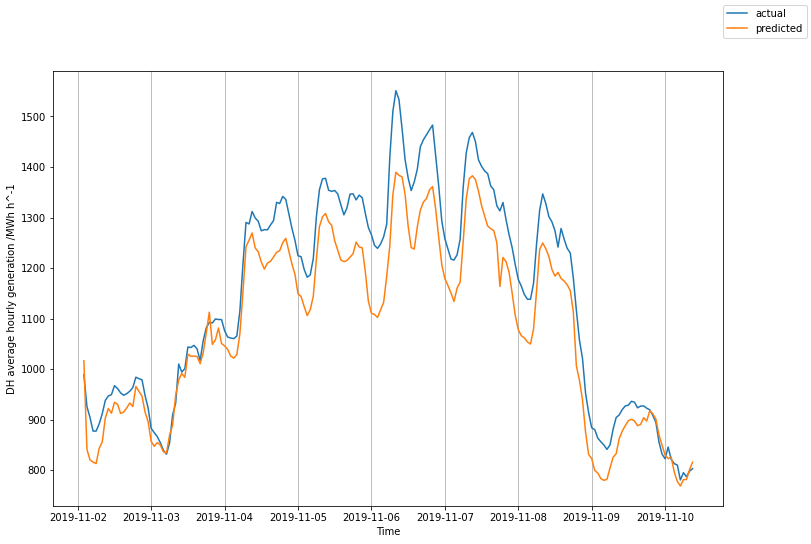

In [50]:
fig = plot_error_location(5, greatest_error_indices)
plt.show()